# __Activity 2__
## Rachel Nana, October 2018

__Importing Packages__

In [1]:
import pandas as pd
import sklearn
import numpy as np

__Importing Telco Data__

In [2]:
telco = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv');

__Data Prep__

producing indicators

In [3]:
Male_ind = telco['gender'].eq('Male').mul(1)
Partner_ind = telco['Partner'].eq('Yes').mul(1)
Dependents_ind = telco['Dependents'].eq('Yes').mul(1)
PhoneService_ind = telco['PhoneService'].eq('Yes').mul(1)
MultipleLines_ind = telco['MultipleLines'].eq('Yes').mul(1)
FiberOptic_ind = telco.rename(columns={'InternetService':'FiberOptic'})['FiberOptic'].eq('Fiber optic').mul(1)
DSL_ind = telco.rename(columns={'InternetService':'DSL'})['DSL'].eq('DSL').mul(1)
OnlineSecurity_ind = telco['OnlineSecurity'].eq('Yes').mul(1)
OnlineBackup_ind = telco['OnlineBackup'].eq('Yes').mul(1)
DeviceProtection_ind = telco['DeviceProtection'].eq('Yes').mul(1)
TechSupport_ind = telco['TechSupport'].eq('Yes').mul(1)
StreamingTV_ind = telco['StreamingTV'].eq('Yes').mul(1)
StreamingMovies_ind = telco['StreamingMovies'].eq('Yes').mul(1)
Contract_dummies=pd.get_dummies(telco['Contract'], drop_first=True)
PaperlessBilling_ind = telco['PaperlessBilling'].eq('Yes').mul(1)
PaymentMethod_dummies=pd.get_dummies(telco['PaymentMethod'], drop_first=True)
Churn_ind = telco['Churn'].eq('Yes').mul(1)

features

In [4]:
X = pd.concat([Male_ind, telco['SeniorCitizen'], Partner_ind, Dependents_ind, telco['tenure'], PhoneService_ind, MultipleLines_ind, FiberOptic_ind, DSL_ind, OnlineSecurity_ind, OnlineBackup_ind, DeviceProtection_ind, TechSupport_ind, StreamingTV_ind, StreamingMovies_ind, Contract_dummies, PaperlessBilling_ind, PaymentMethod_dummies, telco['MonthlyCharges'], telco['TotalCharges']], axis=1)
print(X[:5])
print(X.shape)

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  FiberOptic  DSL  OnlineSecurity      ...       StreamingTV  \
0              0           0    1               0      ...                 0   
1              0           0    1               1      ...                 0   
2              0           0    1               1      ...                 0   
3              0           0    1               1      ...                 0   
4              0           1    0               0      ...                 0   

   StreamingMovies  One year  Two year  PaperlessBilling  \
0                0         0    

encoding

In [5]:
from sklearn import preprocessing
for column in X.columns:
    if X[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])

dependent variable

In [6]:
y = Churn_ind
print(y[:5])
print(y.shape)

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int32
(7043,)


split the data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

feature scaling

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Hyperparameter Tuning

__Part 1: Base Model__

In [9]:
from sklearn.tree import DecisionTreeClassifier

train model

In [10]:
tree_base = DecisionTreeClassifier()
tree_base = tree_base.fit(X_train, y_train);

cross validation scores

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_roc_base = cross_val_score(tree_base, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc_base)
print(roc_score)

0.646589834109


__Part 2: "Naive" Sweeps__

Testing criterion "gini" vs "entropy":

In [12]:
clf = DecisionTreeClassifier(criterion="gini")
clf.fit(X_train, y_train)
cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print(roc_score)

0.646034979767


In [13]:
clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X_train, y_train)
cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print(roc_score)

0.662961253558


_criterion = "entropy" performed slightly better._

Sweeping through max_depth param (values 1-20), where criterion="gini":

In [14]:
aucs = dict()

for i in range(1,20):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=i)
    clf = clf.fit(X_train, y_train)
    cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    roc_score = np.mean(cross_val_roc)
    aucs[i] = roc_score
    
print(aucs)

{1: 0.66856726721655779, 2: 0.75687267504668454, 3: 0.79715024113767141, 4: 0.8147684015275154, 5: 0.81498207146731327, 6: 0.80826620441514874, 7: 0.79906004117235463, 8: 0.77793135901087962, 9: 0.75221743785738582, 10: 0.72204728239509852, 11: 0.71298948622272129, 12: 0.69781654112393066, 13: 0.68570826265658436, 14: 0.67729686420934132, 15: 0.66684414441940409, 16: 0.65560966486601402, 17: 0.65051047285038077, 18: 0.65787285567194864, 19: 0.64860972233114689}


_When criterion = "gini", max_\__depth = 5 performed best._

Sweeping through max_depth param (values 1-20), where criterion="entropy":

In [15]:
aucs = dict()

for i in range(1,20):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    clf = clf.fit(X_train, y_train)
    cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    roc_score = np.mean(cross_val_roc)
    aucs[i] = roc_score
    
print(aucs)

{1: 0.64450094342518416, 2: 0.73942328866622975, 3: 0.79355063096899126, 4: 0.82166284787830546, 5: 0.8269580181353785, 6: 0.82732510400443271, 7: 0.81370763790644052, 8: 0.79976727249204527, 9: 0.775768810299301, 10: 0.75991463702355522, 11: 0.74348809958854079, 12: 0.7358157066888551, 13: 0.71764962949774247, 14: 0.70545897618852671, 15: 0.69501346237186501, 16: 0.68862406312665225, 17: 0.67670826857057342, 18: 0.67473812066039796, 19: 0.67389621803537958}


_When criterion = "entropy", max_\__depth = 6 performed best._

Sweeping through min_samples_split (values 2-20), where criterion="entropy" and max_depth = 6:

In [16]:
aucs = dict()

for i in range(2,20):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_split=i)
    clf = clf.fit(X_train, y_train)
    cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    roc_score = np.mean(cross_val_roc)
    aucs[i] = roc_score
    
print(aucs)

{2: 0.82775509989316354, 3: 0.82810241617332614, 4: 0.82767613305292653, 5: 0.82825214505748712, 6: 0.828229244273054, 7: 0.82796230694194772, 8: 0.82791611856941016, 9: 0.82777323234071731, 10: 0.82773441637052891, 11: 0.82798966518631156, 12: 0.82826375907224903, 13: 0.82828430697874, 14: 0.82825180620684657, 15: 0.82803880839452548, 16: 0.82748984806203152, 17: 0.82789300940845012, 18: 0.82806117830684978, 19: 0.82815487139860644}


_When criterion = "entropy" and max_\__depth = 6, min_\__samples_\__split = 13 performed best._

__Part 3: RandomizedSearchCV__

In [17]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

parameter distribution from which the model will sample

In [21]:
param_dist_r = {"criterion": ["gini", "entropy"], 
              "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "max_features": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "max_leaf_nodes": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
              "presort": ["True", "False"], 
              "splitter": ["best", "random"]}

train model

In [22]:
tree = DecisionTreeClassifier()
tree_rand_cv = RandomizedSearchCV(tree, param_dist_r, cv=10)
tree_rand_cv.fit(X_train,y_train);

print results

In [23]:
print("Tuned Decision Tree Parameters (Random Search): {}".format(tree_rand_cv.best_params_))

Tuned Decision Tree Parameters (Random Search): {'splitter': 'best', 'presort': 'False', 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_leaf_nodes': 18, 'max_features': None, 'max_depth': 13, 'criterion': 'entropy'}


cross validation scores

In [24]:
cross_val_roc = cross_val_score(tree_rand_cv, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print(roc_score)

0.806704241654


__Part 4: GridSearchCV__

In [25]:
from sklearn.model_selection import GridSearchCV

parameter distribution from which the model will sample

In [27]:
param_dist_g = {"criterion": ["gini", "entropy"], 
              "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
              "max_features": [2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
              "max_leaf_nodes": [2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10], 
              "presort": ["True", "False"], 
              "splitter": ["best", "random"]}

train model

In [28]:
tree_grid_cv = GridSearchCV(tree, param_dist_g, cv=10)
tree_grid_cv.fit(X_train,y_train);

print results

In [29]:
print("Tuned Decision Tree Parameters (Grid Search): {}".format(tree_grid_cv.best_params_))

Tuned Decision Tree Parameters (Grid Search): {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 7, 'presort': 'False', 'splitter': 'random'}


## Tree Visualization

__Part 1: Base Model__

Visualize

In [35]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data1 = StringIO()
export_graphviz(tree_base, out_file=dot_data1, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data1.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_base_model.pdf")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.628973 to fit



True

__Part 2: "Naive" Sweeps__

Train Model

In [37]:
tree_naive = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_split=13)
tree_naive = tree_naive.fit(X_train, y_train)

Visualize

In [38]:
dot_data2 = StringIO()
export_graphviz(tree_naive, out_file=dot_data2, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_naive_sweeps.pdf")

True

__Part 3: Random Search__

Train Model

In [41]:
tree_rand = DecisionTreeClassifier(criterion="entropy", max_depth=13, max_features=None, max_leaf_nodes=18, min_samples_leaf=20, 
                                   min_samples_split=16, presort="False", splitter="best")
tree_rand = tree_rand.fit(X_train, y_train)

Visualize

In [42]:
dot_data3 = StringIO()
export_graphviz(tree_rand, out_file=dot_data3, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data3.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_random_search.pdf")

True

__Part 4: Grid Search__

Train Model

In [43]:
tree_grid = DecisionTreeClassifier(criterion="gini", max_depth=6, max_features=None, max_leaf_nodes=None, min_samples_leaf=5, 
                                   min_samples_split=7, presort="False", splitter="random")
tree_grid = tree_grid.fit(X_train, y_train)

Visualize

In [44]:
dot_data4 = StringIO()
export_graphviz(tree_grid, out_file=dot_data4, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data4.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_grid_search.pdf")

True

## ROC Curves

__Part 1: Base Model__

Predictions

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

predictions1 = tree_base.predict_proba(X_test)
roc_score_base = roc_auc_score(y_test, predictions1[:,1])
print(roc_score_base)

0.639439947416


ROC curve

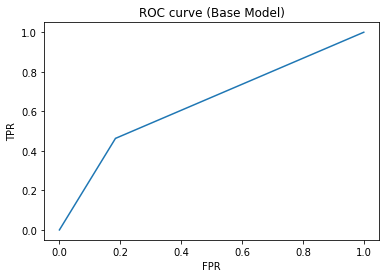

In [95]:
fpr1, tpr1, _ = roc_curve(y_test, predictions1[:,1])
plt.plot(fpr1, tpr1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Base Model)')
plt.show()

__Part 2: "Naive" Sweeps__

Predictions

In [96]:
predictions2 = tree_naive.predict_proba(X_test)
roc_score_naive = roc_auc_score(y_test, predictions2[:,1])
print(roc_score_naive)

0.842136180608


ROC curve

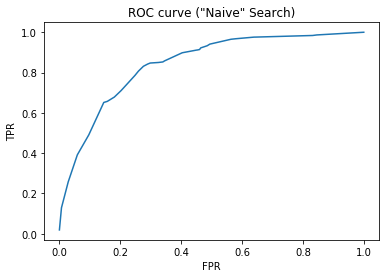

In [97]:
fpr2, tpr2, _ = roc_curve(y_test, predictions2[:,1])
plt.plot(fpr2, tpr2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve ("Naive" Search)')
plt.show()

__Part 3: Random Search__

Predictions

In [98]:
predictions3 = tree_rand.predict_proba(X_test)
roc_score_rand = roc_auc_score(y_test, predictions3[:,1])
print(roc_score_rand)

0.842397548832


ROC curve

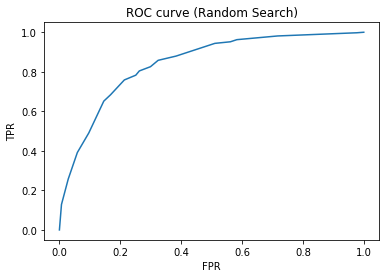

In [99]:
fpr3, tpr3, _ = roc_curve(y_test, predictions3[:,1])
plt.plot(fpr3, tpr3)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Random Search)')
plt.show()

__Part 4: Grid Search__

Predictions

In [100]:
predictions4 = tree_grid.predict_proba(X_test)
roc_score_grid = roc_auc_score(y_test, predictions4[:,1])
print(roc_score_grid)

0.84561548335


ROC curve

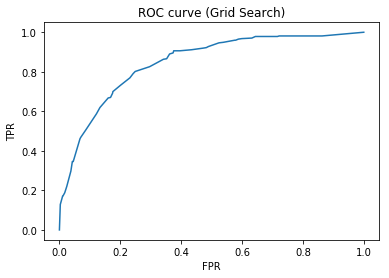

In [83]:
fpr4, tpr4, _ = roc_curve(y_test, predictions4[:,1])
plt.plot(fpr4, tpr4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Grid Search)')
plt.show()

__Combined__

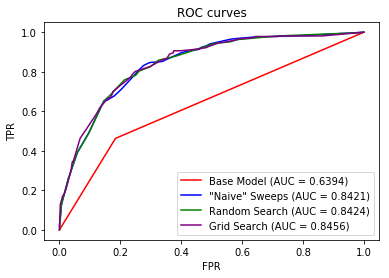

In [104]:
plt.plot(fpr1, tpr1, color='red', label='Base Model (AUC = %0.4f)' % roc_score_base)
plt.plot(fpr2, tpr2, color='blue', label='"Naive" Sweeps (AUC = %0.4f)' % roc_score_naive)
plt.plot(fpr3, tpr3, color='green', label='Random Search (AUC = %0.4f)' % roc_score_rand)
plt.plot(fpr4, tpr4, color='purple', label='Grid Search (AUC = %0.4f)' % roc_score_grid)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.show()